# Phenomenological model for polygon subsidence

In [1]:
from matplotlib import pyplot as plt
import scipy.signal
import sys, os
import numpy as np

In [14]:
#x = [0, 5, 8, 11, 16]
x = [0,1.5,2,6.5,12.5]
z = [4.9, 5.2, 5.3, 5.2, 5.0]
x1 = x[:3]
x2 =x[2:]
z1 = z[:3]
z2 =z[2:]
print (x1,x2)
print (z1,z2)

[0, 1.5, 2] [2, 6.5, 12.5]
[4.9, 5.2, 5.3] [5.3, 5.2, 5.0]


0.3000000000000007 5.3 4.999999999999999


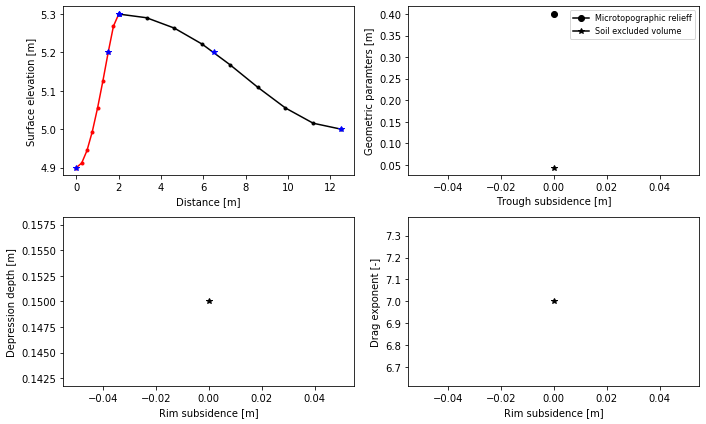

In [15]:
collapse = 0.02
factor = 2.
delta_max = []
delta_ex = []
thaw_depth = []
delta_d = []
delta_c = []
beta = []

fig, ax = plt.subplots(2, 2, figsize=(10,6),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
#fig.tight_layout()
for i in range(0,1,1):

    if i > 0:
        Z1 = [z1[0] - i*collapse, z1[1] - i*collapse/(factor-0.), z1[2]- i*collapse/(factor-0)]
        Z2 = [z2[0] - i*collapse/(factor-0), z2[1] - i*collapse/(factor+.5), z2[2]]
    else:
        Z1 = z1
        Z2 = z2
    if Z2[1] <= Z2[2]:
        Z2[2] = Z2[1]
    cs1 = scipy.interpolate.CubicSpline(x1,Z1, bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,Z2, bc_type='clamped')

    X1 = np.linspace(0,x1[-1],9)
    X2 = np.linspace(x1[-1],x2[-1],9)
    
    
    ax[0].plot(X1, cs1(X1), '.-', color= 'r', label = 'fitted curve')
    ax[0].plot(X2, cs2(X2), '.-', color= 'k')
    ax[0].plot(x1, Z1, '*', color= 'b', label='measured data')
    ax[0].plot(x2, Z2, '*', color= 'b', label='measured data')
    
    XX1 = np.linspace(X1[0],X1[-1],100000)
    XX2 = np.linspace(X2[0],X2[-1],100000)
    integ1 = scipy.integrate.trapz(cs1(XX1)-np.min(cs1(XX1)), x=XX1)#, even='avg')
    integ2 = scipy.integrate.trapz(cs2(XX2)-np.min(cs2(XX2)), x=XX2)#, even='avg')
    
    del_max = round(cs1(X1)[-1] - cs1(X1)[0],4)
    #print (integ1, integ2)
    total = scipy.integrate.cumtrapz(np.concatenate((cs1(XX1),cs2(XX2))), x=np.concatenate((XX1,XX2)),initial=0)
    #print (del_max, (integ1 + integ1) /16.0)
    delta_max.append(del_max)
    delta_ex.append((integ1 + integ1) /16.0)
    thaw_depth.append((z[0] - cs1(XX1)[0]))
    
    #t1 = 0.15 - (z1[-1] - cs1(XX1)[-1])
    t1 = (cs1(XX1)[-1] - cs2(XX2)[-1]) # delta_c = z_rim - z_c
    print (t1,cs1(XX1)[-1],cs2(XX2)[-1])
    if t1> 0.0:#cs1(XX1)[-1] > cs2(XX2)[-1]:
        m = (0.15 - 0.05)/0.3
        delta_d.append(0.15 - m*(0.3 - t1))
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
                       
    if i == 0:
        ax[1].plot(thaw_depth,delta_max, '-o',label='Microtopographic relieff',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',label='Soil excluded volume',color='k')
        ax[2].plot(delta_c,delta_d,'-*',label='delta_d',color='k')
        ax[3].plot(delta_c,beta,'-*',label='drag_coeff',color='k')
    else:
        ax[1].plot(thaw_depth,delta_max, '-o',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',color='k')
        ax[2].plot(delta_c,delta_d,'-*',color='k')
        ax[3].plot(delta_c,beta,'-*',color='k')


ax[0].set_ylabel('Surface elevation [m]')
ax[0].set_xlabel('Distance [m]')
ax[1].set_ylabel('Geometric paramters [m]')
ax[1].set_xlabel('Trough subsidence [m]')

ax[2].set_ylabel('Depression depth [m]')
ax[2].set_xlabel('Rim subsidence [m]')

ax[3].set_ylabel('Drag exponent [-]')
ax[3].set_xlabel('Rim subsidence [m]')


ax[1].legend(loc='best',fontsize=8)
fig.tight_layout()
#plt.savefig(u'/Users/ajc/research/PostProcessing/2019/polygon_subsidence_model/dynamic_sg_coarse.pdf',bbox_inches='tight',dpi=100)

[4.9, 5.2, 5.3] [5.3, 5.2, 5.0]
[4.7, 5.1000000000000005, 5.2] [5.2, 5.12, 5.0]
[4.5, 5.0, 5.1] [5.1, 5.04, 5.0]
[4.300000000000001, 4.9, 5.0] [5.0, 4.96, 4.96]
[4.1000000000000005, 4.8, 4.8999999999999995] [4.8999999999999995, 4.88, 4.88]
[3.9000000000000004, 4.7, 4.8] [4.8, 4.8, 4.8]


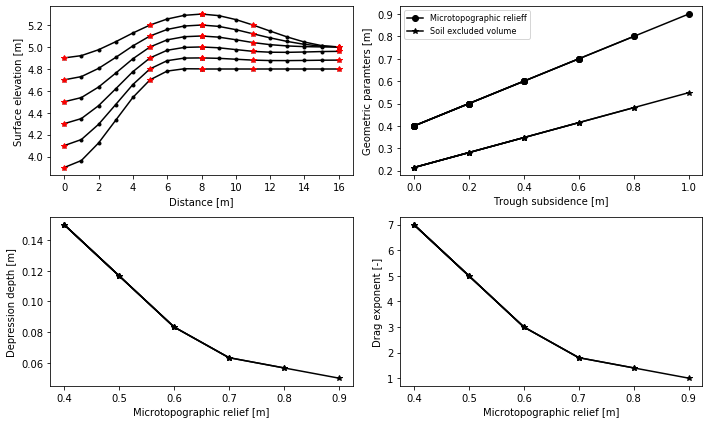

In [119]:
# For coase plot
collapse = 0.02
factor = 2.
delta_max = []
delta_ex = []
thaw_depth = []
trough_subs = []
delta_d = []
delta_c = []
beta = []
rim_collap = []

fig, ax = plt.subplots(2, 2, figsize=(10,6),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
#fig.tight_layout()
for i in range(0,60,10):

    if i > 0:
        Z1 = [z1[0] - i*collapse, z1[1] - i*collapse/(factor-0.), z1[2]- i*collapse/(factor-0)]
        Z2 = [z2[0] - i*collapse/(factor-0), z2[1] - i*collapse/(factor+.5), z2[2]]
    else:
        Z1 = z1
        Z2 = z2
    if Z2[1] <= Z2[2]:
        Z2[2] = Z2[1]
    cs1 = scipy.interpolate.CubicSpline(x1,Z1, bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,Z2, bc_type='clamped')

    X1 = np.linspace(0,8,9)
    X2 = np.linspace(8,16,9)
    
    
    ax[0].plot(X1, cs1(X1), '.-', color= 'k', label = 'fitted curve')
    ax[0].plot(X2, cs2(X2), '.-', color= 'k')
    ax[0].plot(x1, Z1, '*', color= 'r', label='measured data')
    ax[0].plot(x2, Z2, '*', color= 'r', label='measured data')
    print (Z1,Z2)
    XX1 = np.linspace(X1[0],X1[-1],100000)
    XX2 = np.linspace(X2[0],X2[-1],100000)
    integ1 = scipy.integrate.trapz(cs1(XX1)-np.min(cs1(XX1)), x=XX1)#, even='avg')
    integ2 = scipy.integrate.trapz(cs2(XX2)-np.min(cs2(XX2)), x=XX2)#, even='avg')
    
    del_max = round(cs1(X1)[-1] - cs1(X1)[0],4)
    
    total = scipy.integrate.cumtrapz(np.concatenate((cs1(XX1),cs2(XX2))), x=np.concatenate((XX1,XX2)),initial=0)
    
    delta_max.append(del_max)
    delta_ex.append((integ1 + integ1) /16.0)
    #thaw_depth.append(z[0] - (z[0] - cs1(XX1)[0]))
    trough_subs.append((z[0] - cs1(XX1)[0]))
    thaw_depth = trough_subs
    t1 = (cs1(XX1)[-1] - cs2(XX2)[-1]) 
    
    if i ==0:
        rim_collap.append(0.4)
    else:
        rim_collap.append(0.4+0.5*del_max)
    if t1> 0.0:#cs1(XX1)[-1] > cs2(XX2)[-1]:
        m = (0.15 - 0.05)/(0.4-0.1)
        delta_d.append(0.15 - m*(0.3 - t1))
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
                       
    if i == 0:
        #ax[1].invert_xaxis()
        
        ax[1].plot(thaw_depth,delta_max, '-o',label='Microtopographic relieff',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',label='Soil excluded volume',color='k')
        ax[2].plot(delta_max,delta_d,'-*',color='k')
        ax[3].plot(delta_max,beta,'-*',label='drag_coeff',color='k')
    else:
        ax[1].plot(thaw_depth,delta_max, '-o',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',color='k')
        ax[2].plot(delta_max,delta_d,'-*',color='k')
        ax[3].plot(delta_max,beta,'-*',color='k')
        #ax[3].axhline(7,0,0.05,color='k')
        
ax[0].set_ylabel('Surface elevation [m]')
ax[0].set_xlabel('Distance [m]')
ax[1].set_ylabel('Geometric paramters [m]')
ax[1].set_xlabel('Trough subsidence [m]')

ax[2].set_ylabel('Depression depth [m]')
ax[2].set_xlabel('Microtopographic relief [m]')

ax[3].set_ylabel('Drag exponent [-]')
ax[3].set_xlabel('Microtopographic relief [m]')


ax[1].legend(loc='best',fontsize=8)
fig.tight_layout()
plt.savefig(u'/Users/ajc/research/PostProcessing/2019/polygon_subsidence_model/dynamic_sg_coarse.pdf',bbox_inches='tight',dpi=100)

In [15]:
# from Fully low to high centered polygon
x = [0, 5, 8, 11, 16]
z = [5, 4.85, 4.5, 4.85, 5.0]
x1 = x[:3]
x2 =x[2:]
z1 = z[:3]
z2 =z[2:]
print (x1,x2)
print (z1,z2)

[0, 5, 8] [8, 11, 16]
[5, 4.85, 4.5] [4.5, 4.85, 5.0]


In [16]:
print (z,z1,z2)

[5, 4.85, 4.5, 4.85, 5.0] [5, 4.85, 4.5] [4.5, 4.85, 5.0]


[5, 4.85, 4.5] [4.5, 4.85, 5.0]
-0.5000000000000009 4.499999999999999 5.0


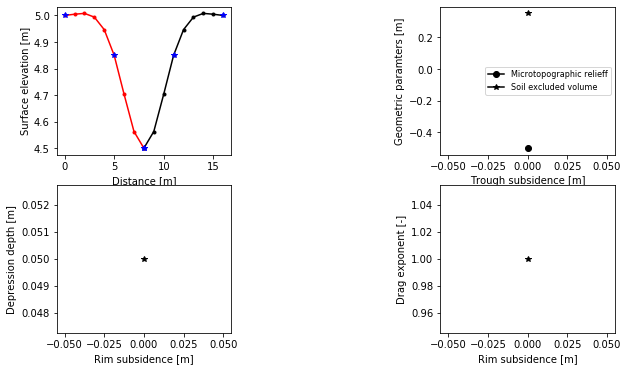

In [17]:
collapse = 0.00
factor = 2.
delta_max = []
delta_ex = []
thaw_depth = []
delta_d = []
delta_c = []
beta = []
print (z1,z2)
fig, ax = plt.subplots(2, 2, figsize=(10,6),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
#fig.tight_layout()
for i in range(0,1,1):

    Z1 = z1
    Z2 = z2
    
    cs1 = scipy.interpolate.CubicSpline(x1,Z1, bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,Z2, bc_type='clamped')

    X1 = np.linspace(0,8,9)
    X2 = np.linspace(8,16,9)
    
    
    ax[0].plot(X1, cs1(X1), '.-', color= 'r', label = 'fitted curve')
    ax[0].plot(X2, cs2(X2), '.-', color= 'k')
    ax[0].plot(x1, Z1, '*', color= 'b', label='measured data')
    ax[0].plot(x2, Z2, '*', color= 'b', label='measured data')
    
    XX1 = np.linspace(X1[0],X1[-1],100000)
    XX2 = np.linspace(X2[0],X2[-1],100000)
    integ1 = scipy.integrate.trapz(cs1(XX1)-np.min(cs1(XX1)), x=XX1)#, even='avg')
    integ2 = scipy.integrate.trapz(cs2(XX2)-np.min(cs2(XX2)), x=XX2)#, even='avg')
    
    del_max = round(cs1(X1)[-1] - cs1(X1)[0],4)
    #print (integ1, integ2)
    total = scipy.integrate.cumtrapz(np.concatenate((cs1(XX1),cs2(XX2))), x=np.concatenate((XX1,XX2)),initial=0)
    #print (del_max, (integ1 + integ1) /16.0)
    delta_max.append(del_max)
    delta_ex.append((integ1 + integ1) /16.0)
    thaw_depth.append((z[0] - cs1(XX1)[0]))
    
    #t1 = 0.15 - (z1[-1] - cs1(XX1)[-1])
    t1 = (cs1(XX1)[-1] - cs2(XX2)[-1]) # delta_c = z_rim - z_c
    print (t1,cs1(XX1)[-1],cs2(XX2)[-1])
    if t1> 0.0:#cs1(XX1)[-1] > cs2(XX2)[-1]:
        m = (0.15 - 0.05)/0.3
        delta_d.append(0.15 - m*(0.3 - t1))
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
                       
    if i == 0:
        ax[1].plot(thaw_depth,delta_max, '-o',label='Microtopographic relieff',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',label='Soil excluded volume',color='k')
        ax[2].plot(delta_c,delta_d,'-*',label='delta_d',color='k')
        ax[3].plot(delta_c,beta,'-*',label='drag_coeff',color='k')
    else:
        ax[1].plot(thaw_depth,delta_max, '-o',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',color='k')
        ax[2].plot(delta_c,delta_d,'-*',color='k')
        ax[3].plot(delta_c,beta,'-*',color='k')


ax[0].set_ylabel('Surface elevation [m]')
ax[0].set_xlabel('Distance [m]')
ax[1].set_ylabel('Geometric paramters [m]')
ax[1].set_xlabel('Trough subsidence [m]')

ax[2].set_ylabel('Depression depth [m]')
ax[2].set_xlabel('Rim subsidence [m]')

ax[3].set_ylabel('Drag exponent [-]')
ax[3].set_xlabel('Rim subsidence [m]')


ax[1].legend(loc='best',fontsize=8)
#fig.tight_layout()
#plt.savefig(u'/Users/ajc/research/PostProcessing/2019/polygon_subsidence_model/dynamic_sg_coarse.pdf',bbox_inches='tight',dpi=100)

In [32]:
x = (8**3 - (-8)**3)/3
x

341.3333333333333

In [91]:
x = np.linspace(0,24,15)
y = 0.0025*(x-12)**2

integ = scipy.integrate.cumtrapz(y, x,initial=0)

y1 = 0.36 - 0.0025*(x-12)**2

integ1 = scipy.integrate.cumtrapz(y1, x,initial=0)


print ('Dmax', max(y) - min(y))
print (integ[-1]/24)

print ('Dmax', max(y1) - min(y1))
print (integ1[-1]/24)

Dmax 0.36
0.12122448979591838
Dmax 0.36
0.2387755102040816


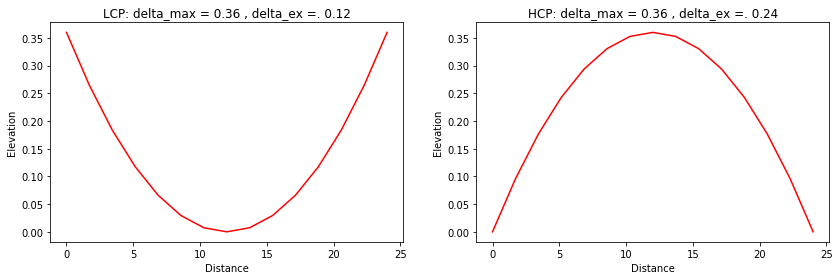

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(12,4),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
plt.subplot(121)
plt.plot(x,y,'r',label='LCP')
plt.title('LCP: delta_max = 0.36 , delta_ex =. 0.12')
plt.xlabel('Distance')
plt.ylabel('Elevation')

plt.subplot(122)
plt.plot(x,y1,'r',label='LCP')
plt.title('HCP: delta_max = 0.36 , delta_ex =. 0.24')
plt.xlabel('Distance')
plt.ylabel('Elevation')

fig.tight_layout()
plt.savefig(u'/Users/ajc/research/PostProcessing/2019/polygon_subsidence_model/parabolic_lcp_hcp.pdf',bbox_inches='tight',dpi=100)